# Classification Setup & Feature Engineering With Instacart!

The first goal of this notebook is to first show how we can take a bunch of raw, relational data and manipulate it into the format of a machine learning problem (binary classification). This is the sort of thing we'll often be given in a business setting - information that's been collected with no clear guidance about how we can frame this information as a predictive task in the $X$ features, $y$ target style.

The second goal of this notebook is to expose you to feature engineering ideas and best practices. Knowing how to select models and tune hyperparameters is very important, but models can only be as good as the quality of the features that you provide to them. In practical machine learning, a huge amount of time is spent engineering and selecting features to add signal to the problem, and you can often get a lot more additional value from well-constructed features than from hyperparameter fine tuning. Hence it's very important to be able to apply domain knowledge, think extensively about what features should matter, and derive them to include in your model.    

**The data for this notebook is a subset of the [kaggle instacart dataset](https://www.kaggle.com/c/instacart-market-basket-analysis/data)**: the files in the `instacart_data_subset` folder are all the same as the original except that all the order data is drawn from a 5000 user subset for the sake of less memory and more speed.  

### Workflow: 

1. **Problem setup and baselining**
2. **Feature engineering to improve our model**
3. **Feature engineering exercises and future ideas**

## 1. Problem setup and baselining

First let's get a quick feel for the data we're working with.

In [1]:
!unzip instacart_data_subset.zip

Archive:  instacart_data_subset.zip
   creating: instacart_data_subset/
  inflating: instacart_data_subset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/instacart_data_subset/
  inflating: __MACOSX/instacart_data_subset/._.DS_Store  
  inflating: instacart_data_subset/aisles.csv  
  inflating: __MACOSX/instacart_data_subset/._aisles.csv  
  inflating: instacart_data_subset/departments.csv  
  inflating: __MACOSX/instacart_data_subset/._departments.csv  
  inflating: instacart_data_subset/instacart_df_X_features.csv  
  inflating: instacart_data_subset/order_products__prior_subset.csv  
  inflating: instacart_data_subset/order_products__train_subset.csv  
  inflating: instacart_data_subset/orders_subset.csv  
  inflating: instacart_data_subset/products.csv  
  inflating: __MACOSX/instacart_data_subset/._products.csv  


In [2]:
import pandas as pd
import numpy as np

path = 'instacart_data_subset/'
df_orders = pd.read_csv(path + 'orders_subset.csv')
df_orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0


In [3]:
df_order_products_prior = pd.read_csv(path + 'order_products__prior_subset.csv')
df_order_products_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1


In [4]:
df_order_products_train = pd.read_csv(path + 'order_products__train_subset.csv')
df_order_products_train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1


We'll want to combine the order/product information with user information, so we'll go ahead and merge the `order_products` tables with the `orders` table.

In [5]:
df_order_products_train = df_order_products_train.merge(df_orders.drop('eval_set', axis=1), on='order_id')
df_order_products_prior = df_order_products_prior.merge(df_orders.drop('eval_set', axis=1), on='order_id')

df_order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53704 entries, 0 to 53703
Data columns (total 9 columns):
order_id                  53704 non-null int64
product_id                53704 non-null int64
add_to_cart_order         53704 non-null int64
reordered                 53704 non-null int64
user_id                   53704 non-null int64
order_number              53704 non-null int64
order_dow                 53704 non-null int64
order_hour_of_day         53704 non-null int64
days_since_prior_order    53704 non-null float64
dtypes: float64(1), int64(8)
memory usage: 4.1 MB


Next we'll set up the classification problem. For the instacart challenge, the given task is to predict which products will show up again in a user's next order based on their entire product order history. We can worry about aggregating to the cart level later, but understand for now that this problem will require us to make **individual binary predictions for every unique user-product combination** in the order history, where the target is 1 or 0 for if that product shows up in the user's next/most current order.    

With that in mind, we'll create a **`df_X` as our ML-formatted dataframe**, with a user-product aggregated version of the `order_products_prior` data. We'll go ahead and count the total # of times the user has ordered each product as our first feature since we're already doing a user-product aggregation.

In [6]:
df_user_product = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = df_order_products_train['user_id'].unique() 
df_X = df_user_product[df_user_product['user_id'].isin(train_ids)]
df_X.head()

,product_id,user_id,user_product_total_orders
0,1,21285,1
1,1,47549,4
2,1,54136,1
3,1,54240,1
4,1,95730,1


Next we need to get our labels. To do this, we'll group our current cart data (`order_products_train`) by user and collect a set of the items in that cart. Then we can merge with `df_X` and iterate through the rows to get labels for whether each product occurs in the latest cart.  

In [7]:
train_carts = (df_order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,21285,1,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
1,3298,21285,1,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
2,4920,21285,3,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
3,6066,21285,2,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
4,6184,21285,6,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0


Nice, now we actually have a dataset that's shaped as a binary classification problem: **`in_cart` is our target**, and **each observation is a unique user-product combination** based on the entire order history for users in our current cart data.



### Turning to EDA and Baselining

With the data formatted into a ML problem, we should start getting a feel for the problem and create some simple visuals. In particular, as we build features we'll want to **look for visual evidence that the data is separable using these features**. Since we'll be using logistic regression for baselining, we ideally want to find indications of linear separability.  

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

We should immediately check out the distribution of our labels and know that we're working with an **imbalanced classification task** (always check this first!). This is analagous to the first step of checking the continuous target distribution in a regression problem. We'll definitely want to account for the imbalance later (though not in this notebook) when we try to optimize our F1 score, the chosen metric for scoring our model.

0    0.901945
1    0.098055
Name: in_cart, dtype: float64


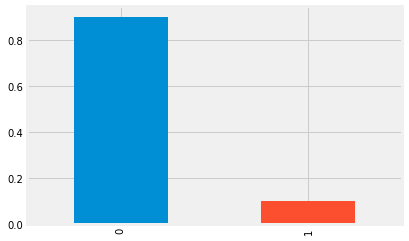

In [9]:
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

Now that we have a feel for our target, we'll start looking for feature-target relationships. Since we'll do this repeatedly on a sample of the data as we build out features, let's write another utility function that generates a seaborn pairplot matrix colored by the target value.  

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


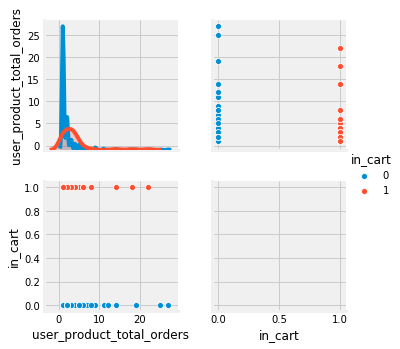

In [10]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(500, random_state=44)) 
    sns.pairplot(sample,hue='in_cart')

plot_features(df_X)

It's a bit hard to see, but in `the user_product_total_orders` plot there's evidence that higher values are associated with higher likelihood of a positive target (this is intuitive). Don't be deceived by the longer right tail for the negative target samples, this is likely an artifact of the class imbalance.

Right now this looks like a very meagre machine learning problem! We only have 1 usable feature and it doesn't look like a strong one - the total orders placed for each user-product combination. Let's use a simple logistic model with this feature as a baseline, and see how much predictive power we can add to this baseline by **building out our feature set with feature engineering**.

For this problem, we want to be **extra careful about validation/testing**. If we do a simple train/test split, we'll end up with users that occur in both the training and test data and run the risk of overfitting to the tendencies of specific users. Instead, we'll manually sample 20% of the users to put into our test set, and use the remaining 80% of users for the training data. Since we'll be doing this several times as we build out feature sets, we'll encapsulate the sampling process in a `get_user_split_data` function that mimics the behavior of sklearn's `train_test_split`. 

In [11]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['in_cart'], df_te['in_cart']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

    return X_tr, X_te, y_tr, y_te

With this splitting function in hand, we're ready to train and evaluate our simple baseline model.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
    
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08205128205128205

The bar is set low!

In [13]:
lr.coef_

array([[0.14978506]])

We can confirm our visual-driven assumption that a higher number of past product orders is associated with higher likelihood of being in the next cart.

## 2. Feature engineering to improve our model

The first thing we need to do is think critically about the predictive task and the types of features that we need to use. We should draw heavily on domain knowledge and be open to trial and error. 

Since our observations are unique combinations of user-product, we'll have multiple sources of features that are highly relevant to making a prediction about the purchasing behavior for the upcoming/most current order. We can break this problem down in terms of **qualities of human behavior** and figure out how to capture them numerically.

### Feature Types:

* **Product** features: general information about product purchase patterns across ALL users. The category of the product, its general popularity, how high priority the item tends to be, etc.
* **User** features: information about specific user behavior. How many items do they tend to order, how long has it been since they've last ordered, what time of day do they usually order, etc. 
* **User-Product** features: information about product-specific user behavior. How often have they ordered this product, how high-priority does it tend to be for them, how long has it been since they've ordered this product, etc.

When engineering 10s or hundreds of features, it can quickly become tricky to keep track of all our code and feature outputs. Here are a couple of best practices:

  1. Use consistent naming conventions for features of the same type 
  2. Build features at the same level of aggregation at the same time, and track them in a dedicated dataframe. Merge back into the ML-formatted dataframe at the end of the process.
  
With this in mind, we'll start with product level features.

### Product features

Here we'll create 2 simple product-level features, merge them into the ML dataframe, and run a new model as a 2nd baselining step. By **iteratively baselining** like this, we can make sure that each set of features we're adding to the mix is adding real predictive value.

We'll gauge each product's overall popularity by counting its total orders across all users, and also gauge its typical priority level in an order by averaging its `add_to_cart_order`.

In [14]:
from collections import OrderedDict

prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (df_order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df_prod_features.head()

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,26,4.576923
1,2,1,3.000000
2,3,1,4.000000
3,4,10,8.100000
4,8,1,25.000000


In [15]:
df_X = df_X.merge(df_prod_features, on='product_id')

df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order
0,1,21285,1,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0,26,4.576923
1,1,47549,4,"{27845, 27790, 13042, 10326, 37687}",0,26,4.576923
2,1,54136,1,"{47977, 5450, 26604, 5296, 11123, 24852, 10070...",0,26,4.576923
3,1,54240,1,"{12427, 26348}",0,26,4.576923
4,1,95730,1,"{39657, 10441, 12427, 37710, 10258, 32921, 45051}",0,26,4.576923


Each time we expand our feature set, lets generate a new set of visuals to study the feature-target relationships and look for separability.   

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


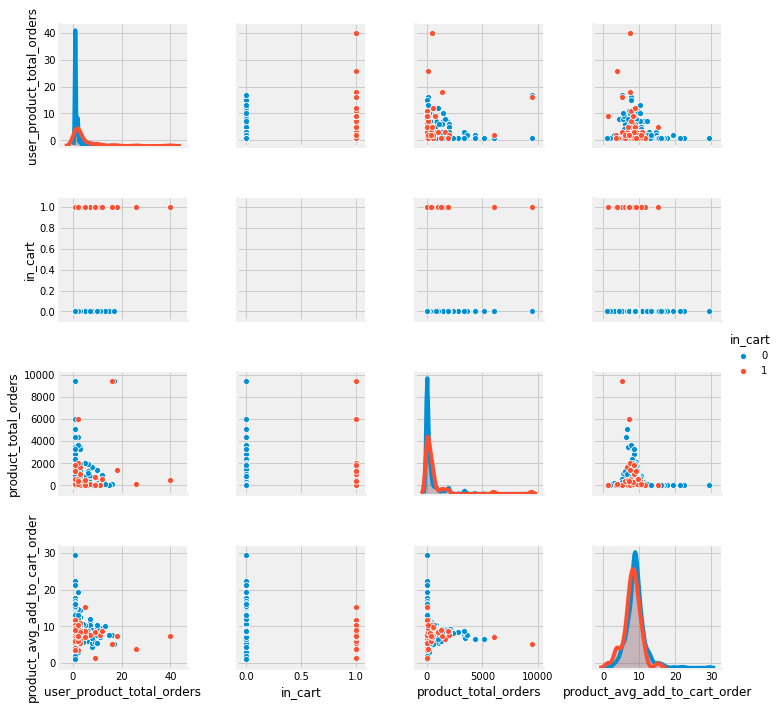

In [16]:
plot_features(df_X)

Well, **this problem still looks hard**. We don't see any strong linear signals or particularly compelling evidence of nonlinear separability in these charts. But we probably do have better signals than before in our 1-feature baseline.

In [17]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.09181524638495017

So we're able to do slightly better with the addition of just a few product specific features.

### User features

Here we'll create 4 user-level features, then merge into `df_X` and benchmarka model as before.

There are a number of components of user behavior that should be critical to measure. We'd like to know if our users have made many or few orders, the average number of products they buy in an order, how many different products they've bought over time, and how long they typically wait between orders. Thinking about purchasing tendencies, all of these factors could play a role in determining what to expect from the next cart.

In [18]:
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_user_features = (df_order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

df_user_features.columns = ['user_id'] + user_features
df_user_features.head()

,user_id,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,50,67,6.761194,89,5.691275
1,52,27,6.259259,51,9.134969
2,65,14,9.428571,80,13.594828
3,80,12,10.666667,52,9.857143
4,220,16,7.125000,44,14.980000


In [19]:
df_X = df_X.merge(df_user_features, on='user_id')
df_X = df_X.dropna() # note that this is naive NaN handling for simplicity
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,21285,1,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0,26,4.576923,48,6.604167,46,8.044872


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


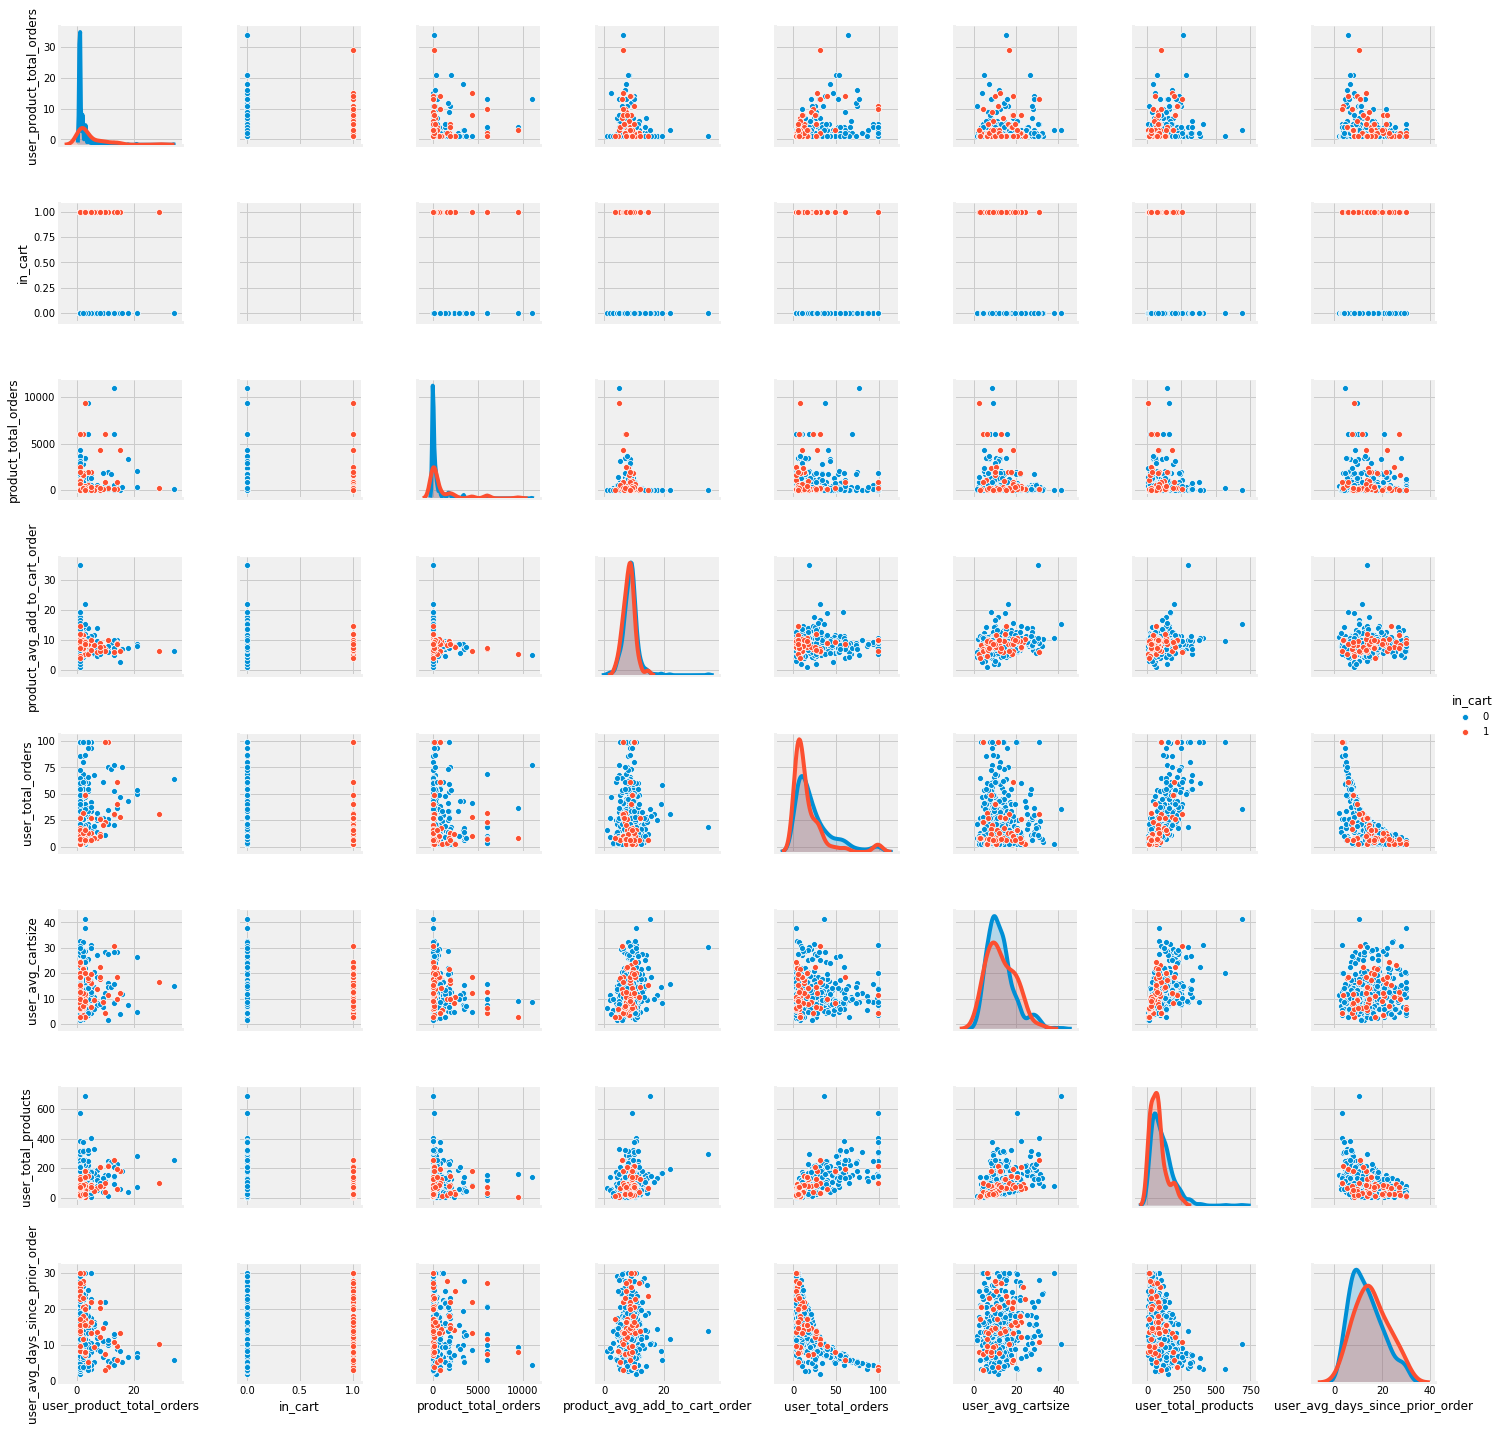

In [20]:
plot_features(df_X)

A lot more features to spend some time looking at now. Do you see any clear separator features or two-way interactions that might be good separators? The problem is still hard, nothing jumps out. 

In [21]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.12756013745704467

Once again, our model improvement confirms that these features were a worthwhile addition of predictive value.

### User-Product features

For our 3rd feature engineering step, we'll create 2 more user-product features to add to our benchmark.

Here we want to get a sense of how much priority each user places on each product by looking at the typical `add_to_cart_order` for that user-product combination. We also want to get a feature for % of times a product occurs across all of a user's orders -- we'll do that at the end by taking the original `user_product_total_orders` feature we grabbed and dividing it by the `user_total_orders` feature we derived in the user features section.

In [22]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (df_order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df_user_prod_features.head()

,product_id,user_id,user_product_avg_add_to_cart_order
0,1,21285,3.0
1,1,47549,4.0
2,1,54136,3.0
3,1,54240,2.0
4,1,95730,1.0


In [23]:
df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id'])
df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq
0,1,21285,1,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0,26,4.576923,48,6.604167,46,8.044872,3.0,0.020833


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


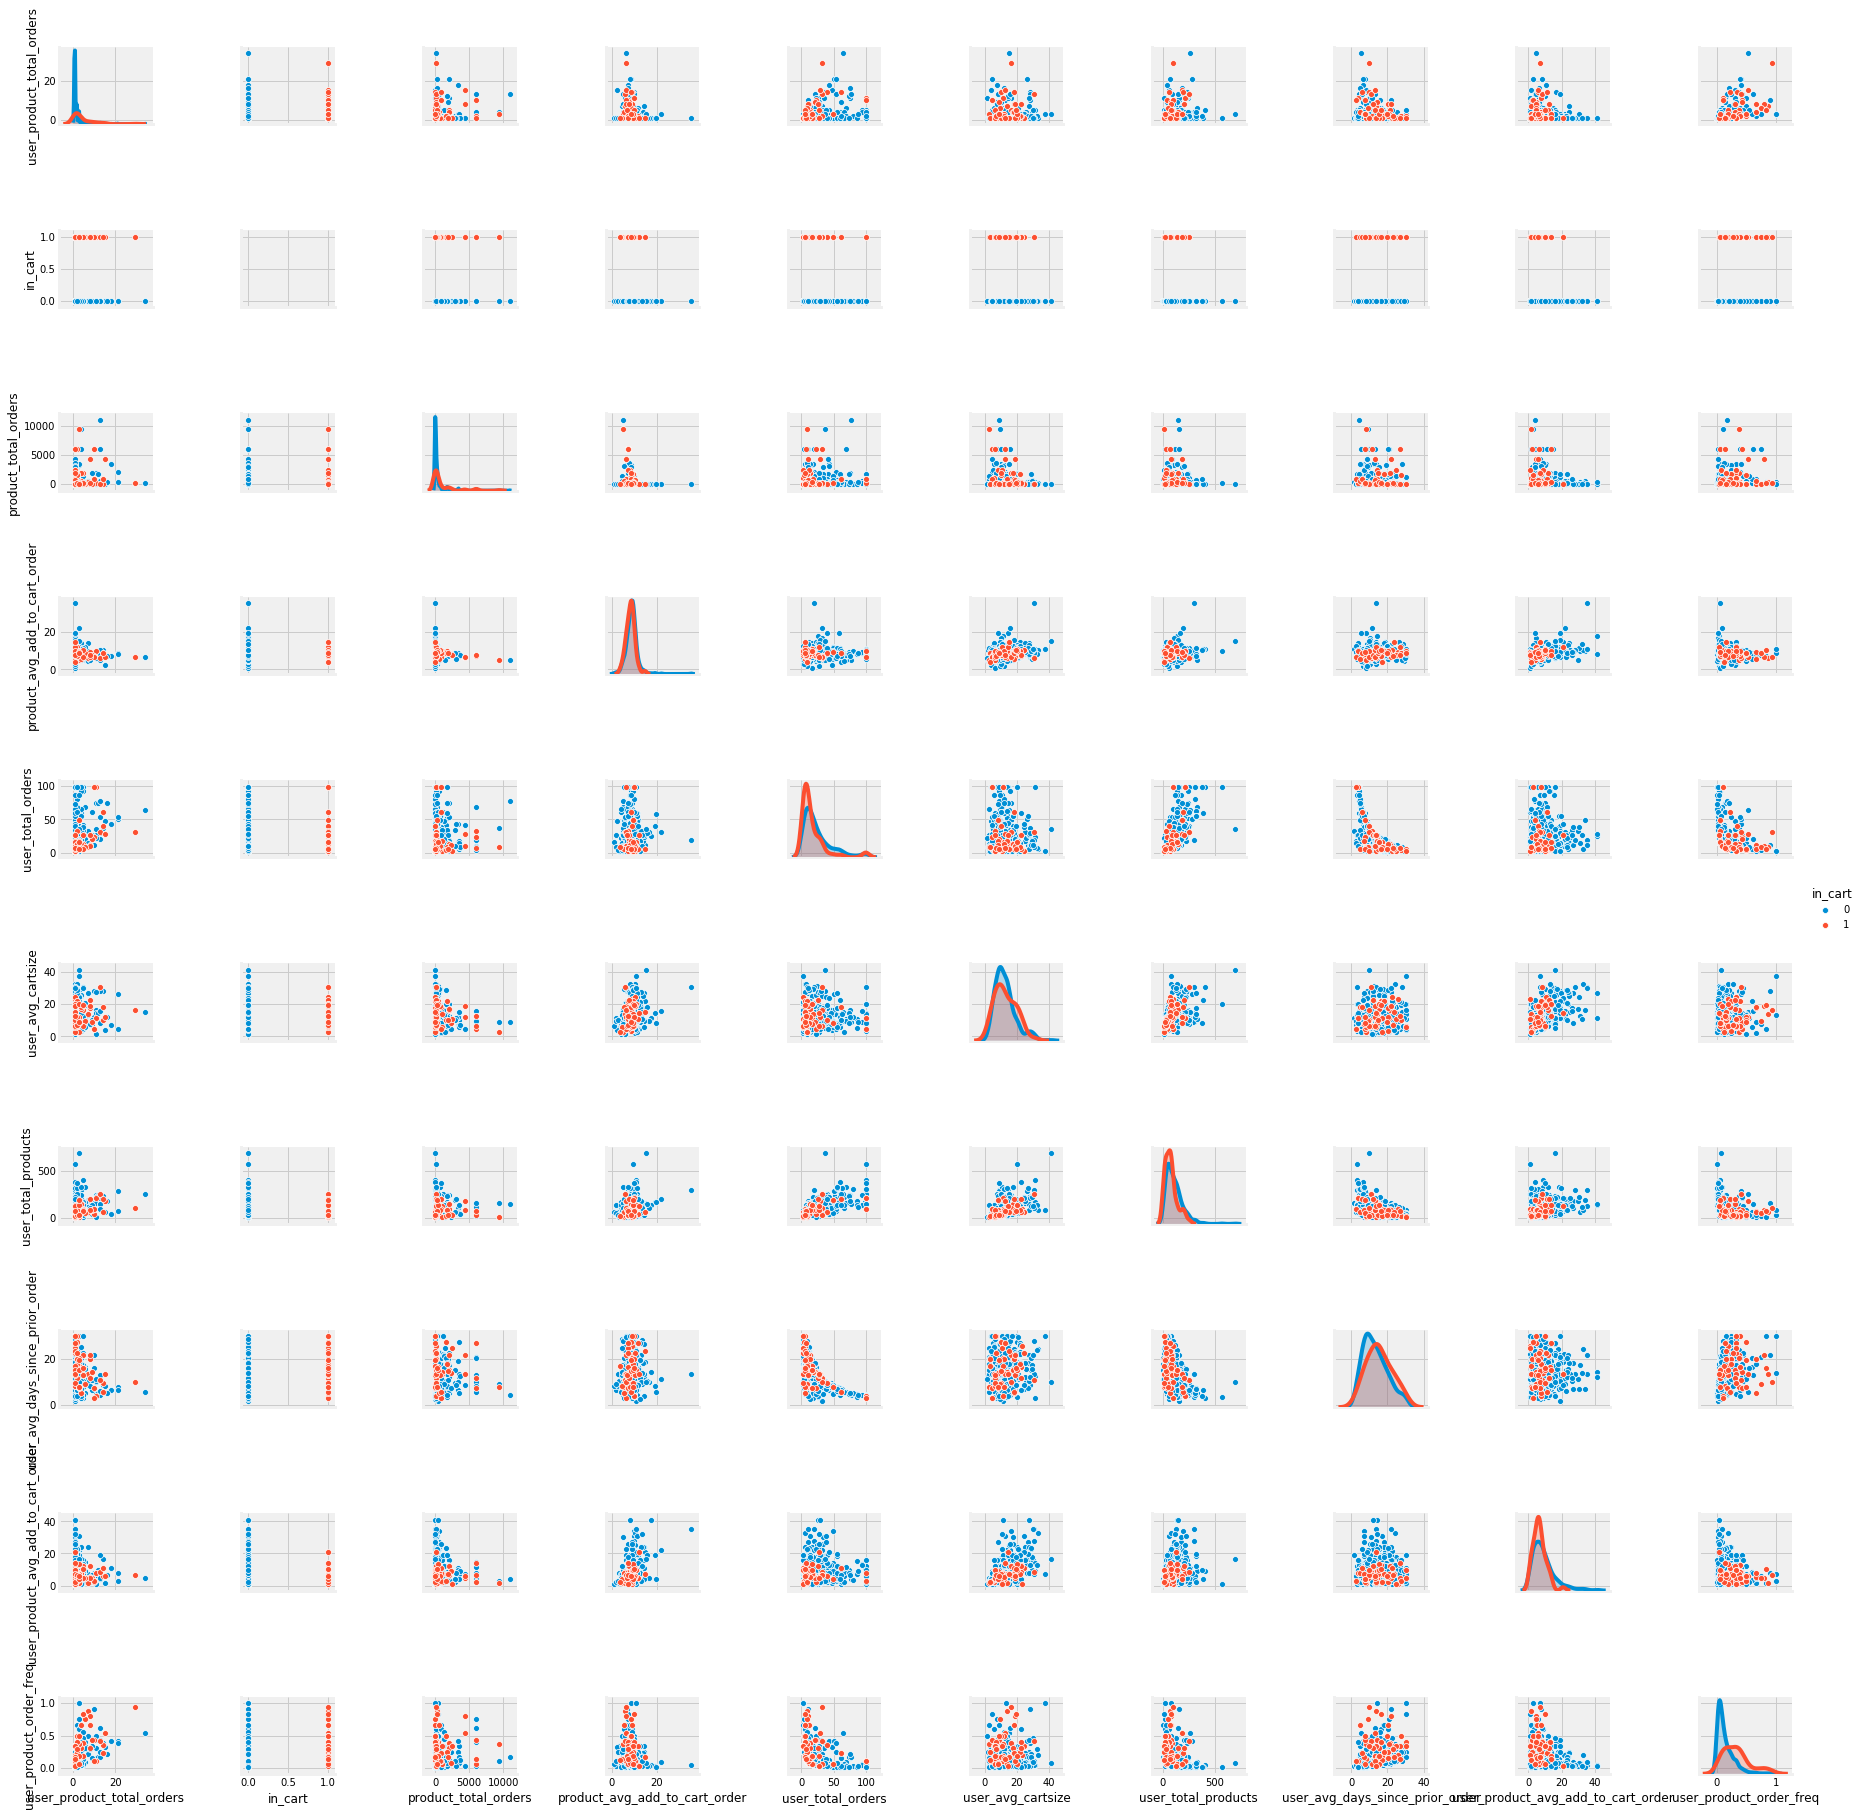

In [24]:
plot_features(df_X)

As we work towards an increasingly complex model (more and more features), it's getting harder to study all the visuals! But look at the bottom row, corresponding to the "user_product_order_freq" feature. There seems to be some separation to be had here, which makes sense - how often a user has ordered a product in the past should matter a lot for predicting the future. So perhaps we've made a bit of a breakthrough, will it reflect in the model score? 

As a hint about model selection for this problem, think about the geometric structure of the relationships above. Do they really look very linear? Our EDA already suggests that nonlinear models may do better.

In [25]:
X_tr, X_te, y_tr, y_te = get_user_split_data(df_X)

lr = LogisticRegression()
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.21642266072565244

We've come a long way, but have a ways yet to go. We should be able to improve our F1 with a combination of:

    1. More/better features
    2. More training data (we have lots more available)
    3. Better handling of the class imbalance issue / decision threshold (topic for future lecture)
    4. More sophisticated models

In [26]:
#Saving our ML dataframe with features for future use:
df_X.to_csv('instacart_data_subset/instacart_df_X_features.csv', index=False)

## 3. Feature engineering exercises and future ideas

In [27]:
# Add product category / aisle information as categorical features 

In [28]:
# Add another user-product feature that computes how many orders it's been since the user ordered that product 


In [29]:
# Add another user-product feature that computes the % of times a product shows up consecutively in the user's orders
# (i.e. they reordered it immediately in the next order)


In [30]:
# We haven't used the data on order time / day of week at all yet. We could use this to measure the typical times 
# products tend to be ordered (both generically and at the user-product level), and quantify the difference
# between the time of the latest order and these typical times to pick up new signal around ordering patterns.

# Modify the product and user-product features to compute average hour of day and day of week. Add these to df_X,
# Then add features of the form user_product_avg_hod_delta that take the dif of the current order time and the avg. 


In [ ]:
# So far the way we've used the order history treats the entire history on equal terms - for example, user-product 
# order frequency treats orders from months ago the same as recent ones. Come up with features that focus more
# on the most recent orders or give them more weight than older ones.